# Categorizing US State-Level Trends of COVID-19 Cases using Hierarchical Clustering

The novel coronavirus has spread rapidly across the US, but the trends of individual states have been far from uniform. Though the exact reasons for the discrepancies are not fully known, some hypotheses range from the varied policies enacted by the states, to the seasonal weather patterns. For example, while in the Northeast people might spend more time outside throughout the summer, in the hot and humid South, residents might feel more inclined to stay indoors. These factors, and even inconspicuous ones such as airport size and the prevalence of public transportation may play a role in how and where the virus spreads. Categorizing transmission rates by grouping those with similar trends will help uncover whether these commonalities are driven by underlying factors, which can help inform policy.

In [1]:
import pandas as pd
import os   
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt 
import scipy as sp
from scipy.cluster import hierarchy
import scipy.cluster.hierarchy as spc
from scipy.cluster.hierarchy import dendrogram
import folium
import geopandas
import seaborn as sns
sns.set()

In [2]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

In [3]:
def StateData():
    filename = '/Users/mtekant/Documents/Python Projects/COVID 19/covid-19-data-master/us-states.csv'
    df = pd.read_csv(filename)
    return df

def allData():
    df = StateData()
    df = df.groupby(['date']).apply(lambda x : x.loc[:,['cases','deaths']].sum(axis=0))
    df['daily_cases']=df['cases'].values
    df['daily_deaths']=df['deaths'].values
    df.loc[:,'daily_cases'].iloc[1:] = df.loc[:,'cases'].values[1:]-df.loc[:,'cases'].values[:-1]
    df.loc[:,'daily_deaths'].iloc[1:] = df.loc[:,'deaths'].values[1:]-df.loc[:,'deaths'].values[:-1]
    df['7day_avg_cases'] = df.loc[:,'daily_cases'].rolling(7).apply(lambda x: np.nanmean(x)).values
    df['7day_avg_deaths'] = df.loc[:,'daily_deaths'].rolling(7).apply(lambda x: np.nanmean(x)).values
    df = df.fillna(0.)
    return df

In [4]:
allCases=allData()

#### Plotting the daily cases and deaths in the US -- sanity check

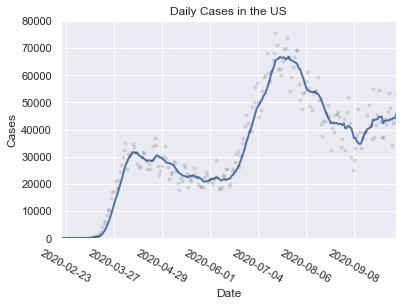

In [5]:
fig, ax=plt.subplots(1,1)
yvals=allCases.loc[:,'daily_cases'].values
yvals2 = allCases.loc[:,'7day_avg_cases'].values
xvals=np.arange(0,yvals.size,np.round(yvals.size/8)).astype(int)
ax.plot(yvals2,'b-',linewidth=2)
ax.set_xticks(xvals)
ax.set_xticklabels(allCases.index[xvals],rotation=-30)
ax.plot(yvals,'k.',alpha=0.1)
plt.title('Daily Cases in the US')
plt.ylabel('Cases')
plt.xlabel('Date');
ax.set_xlim([30,260]);
ax.set_ylim([-10,80000])
plt.savefig('dailycasesUS.pdf',dpi=300,bbox_inches='tight')

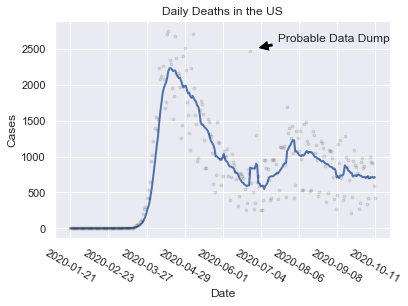

In [6]:
fig, ax=plt.subplots(1,1)
yvals=allCases.loc[:,'daily_deaths'].values
yvals2 = allCases.loc[:,'7day_avg_deaths'].values
xvals=np.arange(0,yvals.size,np.round(yvals.size/8)).astype(int)
ax.plot(yvals2,'b-',linewidth=2)
ax.set_xticks(xvals)
ax.set_xticklabels(allCases.index[xvals],rotation=-30)
plt.title('Daily Deaths in the US')
plt.ylabel('Cases')
plt.xlabel('Date')
ax.plot(yvals,'k.',alpha=0.1)
plt.annotate('Probable Data Dump',xy=(160,2500),xytext=(180, 2600),arrowprops=dict(facecolor='black',shrink=0.1));
plt.savefig('dailydeathsUS.pdf',dpi=300,bbox_inches='tight')

In [7]:
allStatesData=StateData()

In [8]:
# Let's make a pivot table such that the states can be arranged correctly

states_ddpivot=allStatesData.pivot_table(values='deaths',index='date',columns='state').fillna(0.)
states_ddpivot.iloc[1:,:]=states_ddpivot.iloc[1:,:].values-states_ddpivot.iloc[:-1,:].values
states_ddpivot=states_ddpivot.fillna(0.)
states_ddpivot[states_ddpivot<0]=0

states_dcpivot=allStatesData.pivot_table(values='cases',index='date',columns='state').fillna(0.)
states_dcpivot.iloc[1:,:]=states_dcpivot.iloc[1:,:].values-states_dcpivot.iloc[:-1,:].values
states_dcpivot=states_dcpivot.fillna(0.)
states_dcpivot[states_dcpivot<0]=0
states_dcpivot_movav=states_dcpivot.rolling(window=7,axis=0).mean()

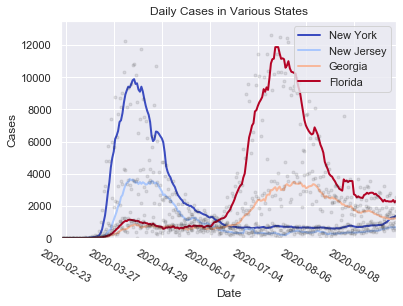

In [9]:

fig, ax = plt.subplots(1,1)
yvals=states_dcpivot.loc[:,'New Jersey'].values
states=['New York','New Jersey','Georgia','Florida']
evenly_spaced_interval = np.linspace(0, 1, len(states))
colors = [mpl.cm.coolwarm(x) for x in evenly_spaced_interval]
for i, color in enumerate(colors):
    ax.plot(states_dcpivot_movav.loc[:,states[i]].values,color=color,linewidth=2)
    
plt.title('Daily Cases in Various States')
xvals=np.arange(0,yvals.size,np.round(yvals.size/8)).astype(int)
ax.set_xticks(xvals)
ax.set_xticklabels(allCases.index[xvals],rotation=-30)
plt.ylabel('Cases')
plt.xlabel('Date')
ax.legend(states);
for i, color in enumerate(states):
    ax.plot(states_dcpivot.loc[:,states[i]].values,'k.',alpha=0.1)
ax.set_xlim([30,260]);
ax.set_ylim([-10,13500])
plt.savefig('dailycases_examp_states.pdf',dpi=300,bbox_inches='tight')

While New York and New Jersey experienced a surge of infections throughout the spring, the southern states of Georgia and Florida remained largely unaffected until the summer. Conversely, New York and New Jersey did not suffer from this summer surge. In addition, none of these states show a significant upwards trend starting in September, indicating that the latest rise in cases in the US must be driven by a different group of states. We can analyze this further using hierarchical clustering.

In [10]:
labels=ax.get_xticklabels()


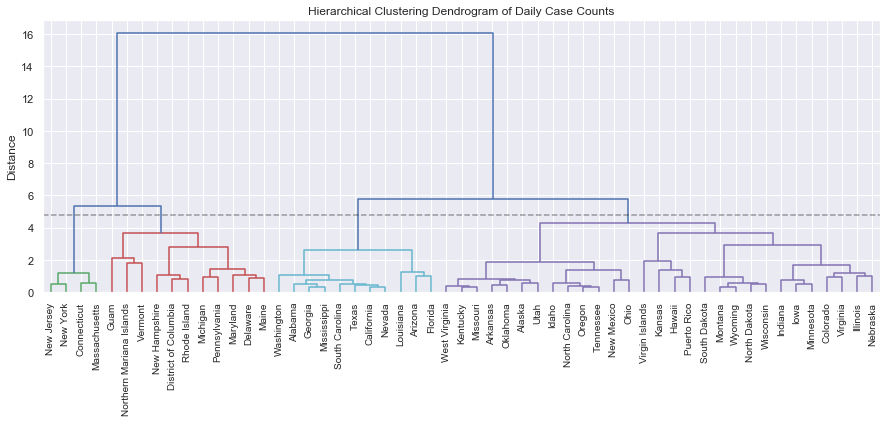

In [11]:
corrdf = states_dcpivot.corr()

pdist = spc.distance.pdist(corrdf)
linkage = spc.linkage(pdist, method='ward')
idx = spc.fcluster(linkage, 3.0, 'distance')
Xsize=15;
fig, ax = plt.subplots(1,1,figsize=[Xsize,Xsize/3])
spc.dendrogram(linkage,color_threshold=5);
#linkage;
#spc.set_link_color_palette(None)
#ax.set_xticks(np.arange(0,states_dcpivot.shape[1]))
labels=ax.get_xticklabels()
#ax.get_xticks()
xlabels=[int(lbl.get_text()) for lbl in labels];
ax.set_xticklabels(states_dcpivot.columns[xlabels],fontsize=10);
plt.title('Hierarchical Clustering Dendrogram of Daily Case Counts');
plt.ylabel('Distance')
ax.axhline(y=4.8,color='k',linestyle='--',alpha=0.4);
plt.savefig('dendrogram.pdf',dpi=300,bbox_inches='tight')

Lots of local clusterings, for example New Jersey-New York-Connecticut-Massachusetts, but also some not so local ones, eg. South Carolina-Texas-California-Nevada branch. California is not connected to other nearby states such as Oregon or Washington, but instead, much more strongly connected to Texas. Let's visualize this clustering on a map.

In [12]:
from sklearn.cluster import AgglomerativeClustering
numgroup=4
stateCluster=AgglomerativeClustering(n_clusters=numgroup,affinity='euclidean',linkage='ward')
StClList=stateCluster.fit_predict(corrdf)/numgroup

In [13]:
s2Map = pd.Series([0.,0.25,0.5,0.75],index=[0.,0.75,0.5,0.25])

In [14]:
StClList
StClList2 = s2Map.loc[StClList].values
# StClList2[StClList==0.5]=0.25
# StClList2[StClList==0.25]=0.5

In [15]:
df_st = pd.Series(StClList2,index=states_dcpivot.columns).reset_index()
df_st.columns = ['State','Group']

In [16]:
df_cpy = df_st.copy()
df_cpy['State'] = [us_state_abbrev[st] for st in df_st['State'].values ]

In [17]:
from branca.colormap import linear

state_geo = os.path.join('/Users/mtekant/Documents/Python Projects/folium-master/examples/data','us-states.json')
#colormap=linear.YlGn_09.scale(df_cpy.Group.min(),df_cpy.Group.max())
colormap=linear.Set1_04.scale(df_cpy.Group.min(),df_cpy.Group.max())
df_dict=df_cpy.set_index('State')['Group']
m = folium.Map([43, -100], zoom_start=4)
folium.GeoJson(
    state_geo,
    name='groups',
    style_function=lambda feature: {
        'fillColor': colormap(0.75-df_dict[feature['id']]),
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5',
        'fillOpacity': 0.6,
    }
).add_to(m)

folium.LayerControl().add_to(m)

m

On the map, it is clear that the states in the same cluster tend to be close to one another, but each cluster has distinct and intriguing properties: the red cluster is split in half by the green one, the purple spans a vast part of the us, and the blue cluster hugs the southern and western coasts. To understand which properties are most important for the formation of clusters, we can look at the cases of a few states in each group and identify the commonalities.

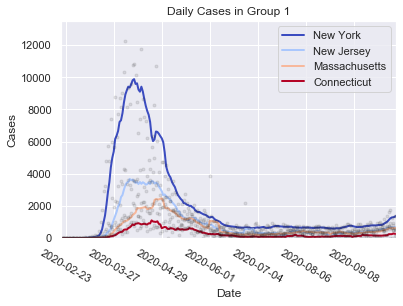

In [18]:
fig, ax = plt.subplots(1,1)
yvals=states_dcpivot.loc[:,'New Jersey'].values
states=['New York','New Jersey','Massachusetts','Connecticut']
evenly_spaced_interval = np.linspace(0, 1, len(states))
colors = [mpl.cm.coolwarm(x) for x in evenly_spaced_interval]
for i, color in enumerate(colors):
    ax.plot(states_dcpivot_movav.loc[:,states[i]].values,color=color,linewidth=2)
    
plt.title('Daily Cases in Group 1')
xvals=np.arange(0,yvals.size,np.round(yvals.size/8)).astype(int)
ax.set_xticks(xvals)
ax.set_xticklabels(allCases.index[xvals],rotation=-30)
plt.ylabel('Cases')
plt.xlabel('Date')
ax.legend(states);
for i, color in enumerate(states):
    ax.plot(states_dcpivot.loc[:,states[i]].values,'k.',alpha=0.1)
ax.set_xlim([30,260]);
ax.set_ylim([-10,13500])
plt.savefig('group1trend.pdf',dpi=300,bbox_inches='tight')

Group 1 contains the states that had a large surge of coronavirus cases starting in March and lasting into June. These were some of the first epicenters of the pandemic. While in the spring they saw cases rising steeply and uncontrollably, this group was largely able to avoid the summer wave that gripped the southern states, possibly by implementing strict social distancing measures and stay-at-home orders. Recently, while some, like New York, have observed another uptick in the cases, the trend has been slow relative to the US transmission rates overall.

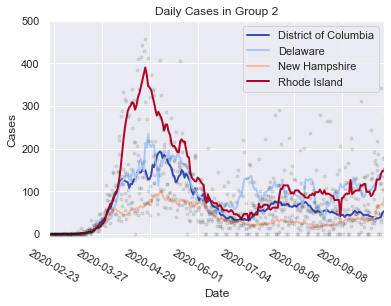

In [19]:
fig, ax = plt.subplots(1,1)
states=['District of Columbia','Delaware','New Hampshire','Rhode Island']
evenly_spaced_interval = np.linspace(0, 1, len(states))
colors = [mpl.cm.coolwarm(x) for x in evenly_spaced_interval]
for i, color in enumerate(colors):
    ax.plot(states_dcpivot_movav.loc[:,states[i]].values,color=color,linewidth=2)
    
plt.title('Daily Cases in Group 2')
ax.set_xticks(xvals)
ax.set_xticklabels(allCases.index[xvals],rotation=-30)
plt.ylabel('Cases')
plt.xlabel('Date')
ax.legend(states);
for i, color in enumerate(states):
    ax.plot(states_dcpivot.loc[:,states[i]].values,'k.',alpha=0.1)
ax.set_xlim([30,260]);
ax.set_ylim([-10,500])
plt.savefig('group2trend.pdf',dpi=300,bbox_inches='tight')

Group 2 contains the states that neighbor those in group 1, but were not themselves the epicenters of the first wave. These states saw a sharp increase in the daily cases just like in group 1, but with a delay of around two to three weeks. Just like in group 1, these states were also able to largely avoid the summer wave, but some have seen a slight upward trend in cases starting in September.

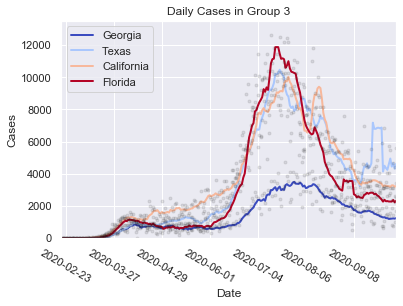

In [20]:
fig, ax = plt.subplots(1,1)
states=['Georgia','Texas','California','Florida']
evenly_spaced_interval = np.linspace(0, 1, len(states))
colors = [mpl.cm.coolwarm(x) for x in evenly_spaced_interval]
for i, color in enumerate(colors):
    ax.plot(states_dcpivot_movav.loc[:,states[i]].values,color=color,linewidth=2)
    
plt.title('Daily Cases in Group 3')
ax.set_xticks(xvals)
ax.set_xticklabels(allCases.index[xvals],rotation=-30)
plt.ylabel('Cases')
plt.xlabel('Date')
ax.legend(states);
for i, color in enumerate(states):
    ax.plot(states_dcpivot.loc[:,states[i]].values,'k.',alpha=0.1)
ax.set_xlim([30,260]);
ax.set_ylim([-10,13500])
plt.savefig('group3trend.pdf',dpi=300,bbox_inches='tight')

Group 3 contains the states with a strong summer peak. Some of these states, such as California, saw a steady rise starting in the spring, but some, like Georgia, remained at a steady level until mid-summer. Yet, all of them experienced a sharp rise starting in June, with the peak arriving in July. These states have seen a significant decline in transmission rates since the summer and have recently been holding a steady rate of daily cases.

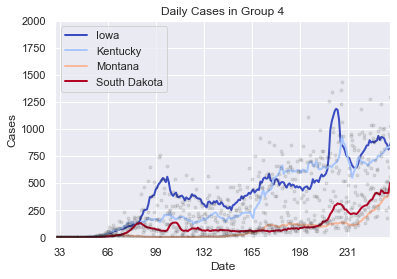

In [21]:
fig, ax = plt.subplots(1,1)
states=['Iowa','Kentucky','Montana','South Dakota']
evenly_spaced_interval = np.linspace(0, 1, len(states))
colors = [mpl.cm.coolwarm(x) for x in evenly_spaced_interval]
for i, color in enumerate(colors):
    ax.plot(states_dcpivot_movav.loc[:,states[i]].values,color=color,linewidth=2)
    
plt.title('Daily Cases in Group 4')
xvals=np.arange(0,yvals.size,np.round(yvals.size/8)).astype(int)
ax.set_xticks(xvals)
plt.ylabel('Cases')
plt.xlabel('Date')
ax.legend(states);
for i, color in enumerate(states):
    ax.plot(states_dcpivot.loc[:,states[i]].values,'k.',alpha=0.1)
ax.set_xlim([30,260]);
ax.set_ylim([-10,2000])
plt.savefig('group4trend.pdf',dpi=300,bbox_inches='tight')

Group 4 contains the Midwest and the neighboring states. Less interconnected, and with a lower population density, these states were able to avoid both the spring and the summer surges. Still, the rate of cases has been steadily rising since the spring, with some states experiencing a significant uptick since September. Making up around half of the new cases, this group is driving the latest surge, followed closely by group 3. Since the rates in group 3 have recently been steady, group 4 could assume an even larger proportion of cases in the upcoming weeks.

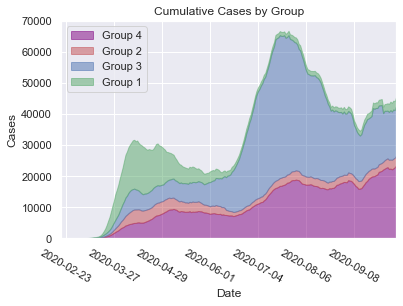

In [22]:
fig, ax = plt.subplots(1,1)

g1tot = states_dcpivot_movav.iloc[:,StClList==0.75].sum(axis=1).values
g2tot = states_dcpivot_movav.iloc[:,StClList==0.25].sum(axis=1).values
g3tot = states_dcpivot_movav.iloc[:,StClList==0.5].sum(axis=1).values
g4tot = states_dcpivot_movav.iloc[:,StClList==0].sum(axis=1).values
s=[np.zeros(g1tot.shape),g4tot, g2tot, g3tot, g1tot]
cmap=['w','purple','r','b','g']
lbls = ['Group 4','Group 2','Group 3','Group 1']
for si,lbl in zip(range(1,len(s)),lbls):
    ax.fill_between(np.arange(0,g1tot.size),sum(s[0:si+1]),sum(s[0:si]),\
                    alpha=0.5,color=cmap[si],label=lbl)
    
plt.title('Cumulative Cases by Group')
ax.set_xticks(xvals)
ax.set_xticklabels(allCases.index[xvals],rotation=-30)
plt.ylabel('Cases')
plt.xlabel('Date')
ax.legend(loc=2)
ax.set_xlim([30,260]);
ax.set_ylim([0,70000])
plt.savefig('cum_casesbygroup.pdf',dpi=300,bbox_inches='tight')

Overall, hierarchical clustering of state level daily case data in the US reveals four groups of states with distinct trends: the northeastern states that experienced the devastating first wave in the early spring, the neighboring states that saw the late spring surge, the south and western coasts that had a large summer peak, and the rest, that have escaped these large-scale outbreaks but now make up the majority of the recent uptick in cases.